In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from scipy.stats import ttest_ind
import spacy

import re

%matplotlib inline

import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
# warnings.filterwarnings('ignore')

In [15]:
# Loading the dataset
df = pd.read_csv('../data/clean/df_0.csv', sep=',')

In [11]:
df

,id,text,target,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
...,...,...,...,...
41637,9043,Not sure what happened but now I have to hit t...,1,neutral
41638,6160,"Pretty good app, lets you organize tasks by ca...",2,positive
41639,5655,This app is a piece of sh**. It won't sync my ...,0,negative
41640,11834,": Very interested. However, low carbs for the ...",2,positive


# Data Preprocessing with spaCy

**Clean the text**

In [17]:
# Preprocess the dataset: removing URLs, mentions and hashtags im 'text' column and convert to lowercase

# Define a function to clean the text
def clean_text(text):
    # Remove URLs, mentions, hashtags, and punctuation
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()  # Convert to lowercase

# Apply the text cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

# Inspect the cleaned text column
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Cooking microwave pizzas, yummy",cooking microwave pizzas yummy
1,Any plans of allowing sub tasks to show up in ...,any plans of allowing sub tasks to show up in ...
2,"I love the humor, I just reworded it. Like sa...",i love the humor i just reworded it like sayi...
3,naw idk what ur talkin about,naw idk what ur talkin about
4,That sucks to hear. I hate days like that,that sucks to hear i hate days like that


<br>
<br>

**Split the Data into Training and Testing Sets**

Before we can fit the TF-IDF vectorizer and train the model, we need to split the dataset into training and testing sets. This allows us to evaluate the model’s performance on unseen data.

Split the dataset into a training set and a testing set.
- Training set: used to fit the TF-IDF vectorizer and train the machine learning model.
- Testing set: used to evaluate the model's performance.

In [24]:
from sklearn.model_selection import train_test_split

# Split the data
X = df['cleaned_text']  # Features (text)
y = df['target']  # Target (sentiment label)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the training and testing sets
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


Training set size: 33313
Testing set size: 8329


<br>
<br>

**Tokenization and Lemmatization with spaCy**
 
 This step will break the text into individual words (tokens) and convert each word to its base form (lemma).This step should happen before fitting the TF-IDF vectorizer, so the vectorizer can work on the final, processed text.

In [30]:
# Load spaCy's small English model
nlp = spacy.load('en_core_web_sm')

# Function to tokenize and lemmatize text and also removes stopwords
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop]  # Lemmatize and remove stopwords

# Apply the tokenization and lemmatization function
df['tokens'] = df['cleaned_text'].apply(tokenize_and_lemmatize)

# Inspect the tokenized and lemmatized text
print(df[['cleaned_text', 'tokens']].head())

                                        cleaned_text  \
0                     cooking microwave pizzas yummy   
1  any plans of allowing sub tasks to show up in ...   
2   i love the humor i just reworded it like sayi...   
3                       naw idk what ur talkin about   
4           that sucks to hear i hate days like that   

                                              tokens  
0                    [cook, microwave, pizza, yummy]  
1                   [plan, allow, sub, task, widget]  
2  [ , love, humor, reword, like, say, group, the...  
3                          [ , naw, idk, ur, talkin]  
4                   [ , suck, hear, hate, day, like]  


In [29]:
df

,id,text,target,sentiment,cleaned_text,tokens
0,9536,"Cooking microwave pizzas, yummy",2,positive,cooking microwave pizzas yummy,"[cook, microwave, pizza, yummy]"
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral,any plans of allowing sub tasks to show up in ...,"[plan, allow, sub, task, widget]"
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive,i love the humor i just reworded it like sayi...,"[ , love, humor, reword, like, say, group, the..."
3,14182,naw idk what ur talkin about,1,neutral,naw idk what ur talkin about,"[ , naw, idk, ur, talkin]"
4,17840,That sucks to hear. I hate days like that,0,negative,that sucks to hear i hate days like that,"[ , suck, hear, hate, day, like]"
...,...,...,...,...,...,...
41637,9043,Not sure what happened but now I have to hit t...,1,neutral,not sure what happened but now i have to hit t...,"[sure, happen, hit, sync, button, time, calend..."
41638,6160,"Pretty good app, lets you organize tasks by ca...",2,positive,pretty good app lets you organize tasks by cat...,"[pretty, good, app, let, organize, task, categ..."
41639,5655,This app is a piece of sh**. It won't sync my ...,0,negative,this app is a piece of sh it wont sync my old ...,"[app, piece, sh, will, not, sync, old, wunderl..."
41640,11834,": Very interested. However, low carbs for the ...",2,positive,very interested however low carbs for the nex...,"[ , interested, low, carb, month, mean, beer]"


In [33]:
# Save the cleaned and tokenized data to a new CSV file
df.to_csv('../data/clean/preprocessed_data.csv', index=False)

<br>
<br>

**Fit the TF-IDF Vectorizer**

Use **TF-IDF** (Term Frequency-Inverse Document Frequency) to convert the text into a numerical format, and then use a model like Logistic Regression or Naive Bayes to classify the sentiment.


In [38]:
# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000) # transforms text data into numerical vectors based on the TF-IDF scoring.
# limits the number of words in the vocabulary to the top 5000 most important terms (based on the term frequency and inverse document frequency).

# Fit the vectorizer on the training data (lemmatized text)
tfidf.fit(X_train) # The vectorizer goes through the training data (X_train) and learns the vocabulary and IDF weights.
# It scans the text and builds a vocabulary of words that it will use to create TF-IDF vectors.
# It calculates the Term Frequency (TF): How often each word appears in a document.
# It calculates the Inverse Document Frequency (IDF): How important a word is, based on how rare it is across the entire dataset.

# After fitting, the vectorizer knows:
# What the important words are based on their frequency across documents.
# How to assign importance to words by calculating the IDF scores.


# Save the vectorizer for future use
with open('../vectorizers/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# pickle.dump(tfidf, f) saves the fitted vectorizer into a file (tfidf_vectorizer.pkl) using the Python library pickle.
# The vectorizer has already learned the vocabulary and the TF-IDF weights from the training data. Saving it ensures that we can reuse the vectorizer later 
# in our application without having to refit it every time.


# What Happens During Fitting:
# Step 1: The vectorizer scans through all the words in your training data (i.e., the lemmatized text).
# Step 2: It calculates the frequency and importance of each word in the context of all the documents.
# Step 3: After this process, the vectorizer knows how to represent new text as vectors.

**Vectorize the Text Using TF-IDF**

In [47]:
# Transform the training and testing data
# Now that the vectorizer is fitted, it can convert the text data into a matrix of TF-IDF scores.

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Shape of training data: {X_train_tfidf.shape}")
# The transform() function takes the cleaned and lemmatized text and converts it into a sparse matrix of TF-IDF features.
# The resulting TF-IDF vectors are numerical representations of the original text that will be used to train and test the machine learning model.

Shape of training data: (33313, 5000)


In [49]:
X_train_tfidf

<33313x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 452919 stored elements in Compressed Sparse Row format>

In [53]:
# Recap:
# Step 1: You initialize the vectorizer, telling it to look for the top 5000 features in the text.
# Step 2: You fit the vectorizer on the training data, which teaches it the vocabulary and calculates TF-IDF scores for the words.
# Step 3: You save the vectorizer so that the same vocabulary and weights can be used later for prediction on new data.
# Step 4: You transform both the training and testing data into TF-IDF vectors, which are ready to be fed into a machine learning model.

# Once this is done, your text data is converted into a numerical format that a machine learning model can work with. 
# Now that you’ve transformed the data, the next step will be to train a machine learning model on the TF-IDF vectors.

<br>
<br>

# Train a Logistic Regression Model

we will train a model to predict the sentiment (positive, neutral, or negative) based on the TF-IDF vectors created from the text data.

Code to Train the Model:
- Train the Logistic Regression Model using the training TF-IDF vectors (*X_train_tfidf*) and the labels (*y_train*).
- Evaluate the model on the testing set (*X_test_tfidf*) to check its accuracy.

In [62]:
from sklearn.linear_model import LogisticRegression


# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the TF-IDF vectors (training data)
model.fit(X_train_tfidf, y_train)

# Save the trained model for future use
with open('../models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

<br>
<br>

**Predict on the test set**

In [68]:
# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Print some predictions and actual labels to check
print(f"Predictions: {y_pred[:10]}")
print(f"Actual labels: {y_test[:10].values}")

Predictions: [0 1 1 1 1 1 2 1 2 1]
Actual labels: [0 1 1 2 0 2 2 0 1 2]


<br>
<br>

Export **y_test** and **y_pred**

In [87]:
import pickle

# Save y_test
with open('../data/clean/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Save y_pred
with open('../data/clean/y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)


<br>
<br>

**Evaluate the Model Performance**

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(y_test, y_pred)

accuracy

0.676191619642214

In [76]:


# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.69      0.63      0.66      2481
     neutral       0.59      0.68      0.63      3038
    positive       0.78      0.72      0.75      2810

    accuracy                           0.68      8329
   macro avg       0.69      0.67      0.68      8329
weighted avg       0.68      0.68      0.68      8329



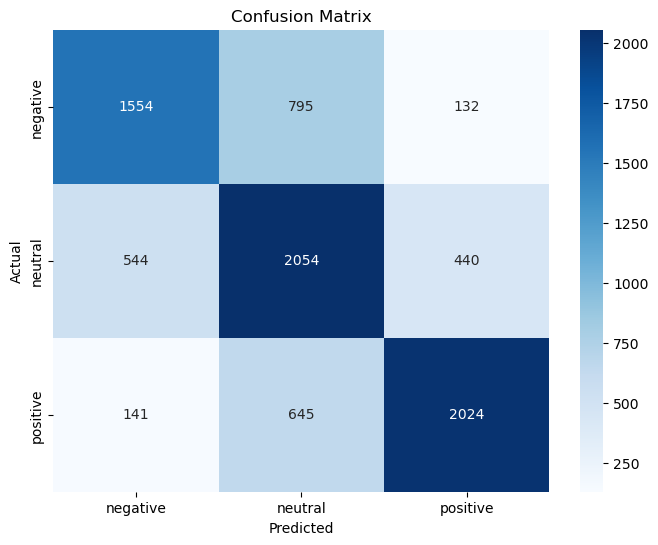

In [78]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()